<a href="https://colab.research.google.com/github/akshay-verma1903/Sentiment-Analysis-Classification/blob/main/Vaccine_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Title : Sentiment Analysis of covid vaccination tweets in India and building classification models using various algorithms.

##Author :- Akshay Verma

##Problem Description 
This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

You are given the following information:

- Id
- date
- content
- username

Import library and download packages required for project

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re
import itertools
import collections
import string
!pip3 install --upgrade openpyxl
pd.set_option("display.max_colwidth", 200)


import nltk # for text manipulation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

     |████████████████████████████████| 242 kB 21.2 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Connect Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#Reading the dataset drom excel file
data_read =  pd.read_excel("drive/MyDrive/Dataset/Vaccine.xlsx")

In [4]:
#Tranfer dataset to anaother variable for further processing
data_df = data_read

**Exploring Our Dataset**

In [5]:
#Checking dataset variable
data_df.head()

,id,date,content,username
0,Sushmi Dey44197.7933101852,2021-01-01,DCGI approval for @SerumInstIndia #Covishield still awaited. Vaccination roll out will have to wait for DCGIâ€¦ https://t.co/I4RdVZYhev,Sushmi Dey
1,Sumi Dutta44197.7002893519,2021-01-01,"Today, there will be no official statement on @CDSCO's expert panel's nod to #Covishield, says @MoHFW_INDIAâ€¦ 🙏 https://t.co/xRuCdsRigJ",Sumi Dutta
2,Mihir Amin44197.6609143519,2021-01-01,Vaccine is almost on the way !!! \n#Covishield #CovidVaccine #seruminstitute,Mihir Amin
3,IndiaToday44197.6478125,2021-01-01,Live: Covishield Gets Emergency Approval In India: :(😢How Soon Coronavirus Vaccine Will Reach You?\n#Covishieldâ€¦ https://t.co/RE3Yc5bbfI,IndiaToday
4,Jashan Joshi44197.6321759259,2021-01-01,Sources were right. Historical day for #India and @SerumInstIndia. India gets Vaccine.😊 #Covishield has been given aâ€¦ https://t.co/I77F0cKXYW,Jashan Joshi


In [6]:
#Renaming Column headers
data_df.rename(columns = {'content':'OriginalTweet','date':'Date','username':'Username','id':'Id'}, inplace = True)

In [7]:
data_df.head(5)

,Id,Date,OriginalTweet,Username
0,Sushmi Dey44197.7933101852,2021-01-01,DCGI approval for @SerumInstIndia #Covishield still awaited. Vaccination roll out will have to wait for DCGIâ€¦ https://t.co/I4RdVZYhev,Sushmi Dey
1,Sumi Dutta44197.7002893519,2021-01-01,"Today, there will be no official statement on @CDSCO's expert panel's nod to #Covishield, says @MoHFW_INDIAâ€¦ 🙏 https://t.co/xRuCdsRigJ",Sumi Dutta
2,Mihir Amin44197.6609143519,2021-01-01,Vaccine is almost on the way !!! \n#Covishield #CovidVaccine #seruminstitute,Mihir Amin
3,IndiaToday44197.6478125,2021-01-01,Live: Covishield Gets Emergency Approval In India: :(😢How Soon Coronavirus Vaccine Will Reach You?\n#Covishieldâ€¦ https://t.co/RE3Yc5bbfI,IndiaToday
4,Jashan Joshi44197.6321759259,2021-01-01,Sources were right. Historical day for #India and @SerumInstIndia. India gets Vaccine.😊 #Covishield has been given aâ€¦ https://t.co/I77F0cKXYW,Jashan Joshi


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39071 entries, 0 to 39070
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             39071 non-null  object        
 1   Date           39071 non-null  datetime64[ns]
 2   OriginalTweet  39071 non-null  object        
 3   Username       34547 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.2+ MB


In [9]:
data_df.shape

(39071, 4)

In [10]:
# Check null values
data_df.isnull().sum()

Id                  0
Date                0
OriginalTweet       0
Username         4524
dtype: int64

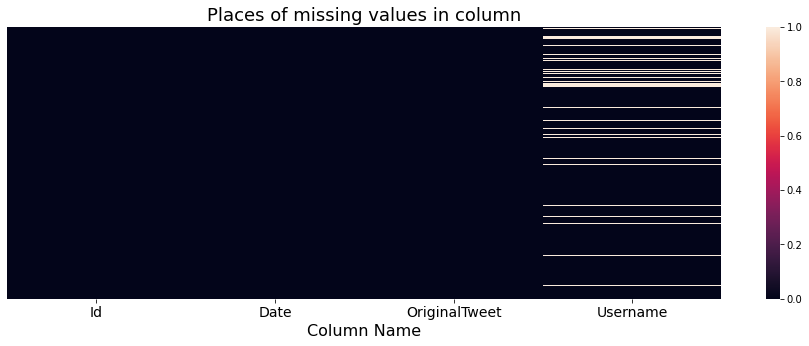

In [11]:
plt.figure(figsize=(16, 5))
sns.heatmap(data_df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column Name", fontsize=16)
plt.xticks(fontsize=14)
plt.title("Places of missing values in column",fontsize=18)
plt.show()

In [12]:
#Removing Duplicate tweets 
data_df = data_df.drop_duplicates('Id')
data_df = data_df.drop_duplicates('OriginalTweet')
print(data_df.shape)


(25363, 4)


**Unique Values In Each Feature Coulmn**

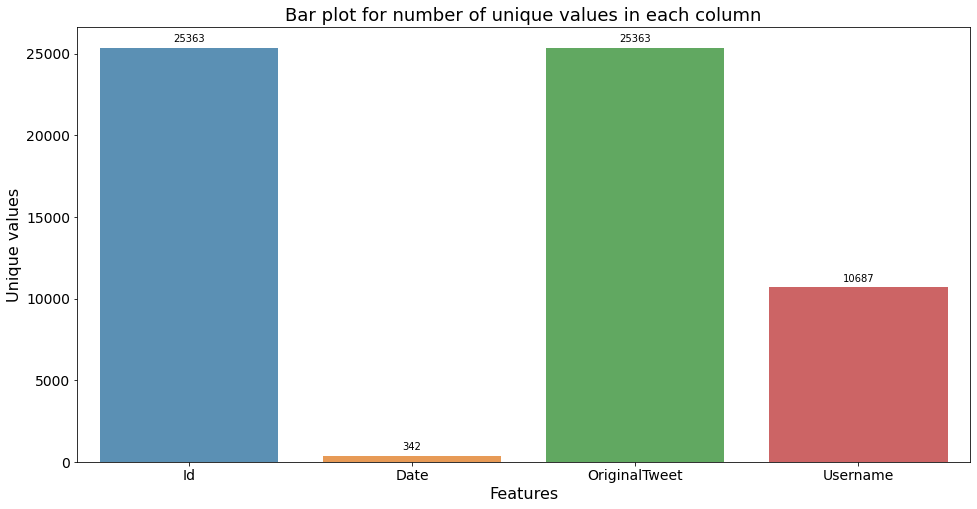

In [13]:
unique_df = pd.DataFrame()
unique_df['Features'] = data_df.columns
unique=[]
for i in data_df.columns:
    unique.append(data_df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(16,8))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column', fontsize=18)
plt.ylabel('Unique values', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Top 10 dates of tweet**

In [14]:
Most_tweet_Date = data_df['Date'].value_counts().head(10)
rc={'figure.figsize':(12,8)}
sns.set_style('white')

Most_tweet_Date_df=pd.DataFrame(Most_tweet_Date)
Most_tweet_Date_df.reset_index(inplace=True)
Most_tweet_Date_df.rename(columns={'index':'Date', 'Date':'Date_Count'}, inplace=True)
Most_tweet_Date_df

,Date,Date_Count
0,2021-11-24,306
1,2021-05-13,304
2,2021-04-21,301
3,2021-06-30,259
4,2021-11-20,251
5,2021-07-03,251
6,2021-05-12,229
7,2021-04-25,222
8,2021-05-25,219
9,2021-11-03,219


**Bottom 10 dates of tweet**

In [15]:
Least_tweet_Date = data_df['Date'].value_counts().tail(10)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

Least_tweet_Date_df=pd.DataFrame(Least_tweet_Date)
Least_tweet_Date_df.reset_index(inplace=True)
Least_tweet_Date_df.rename(columns={'index':'Date', 'Date':'Date_Count'}, inplace=True)
Least_tweet_Date_df

,Date,Date_Count
0,2021-02-15,6
1,2021-02-27,6
2,2021-02-10,5
3,2021-02-24,5
4,2021-02-07,5
5,2021-02-18,5
6,2021-02-02,5
7,2021-02-16,4
8,2021-10-03,4
9,2021-02-23,4


**Data Preprocessing**

In [16]:
#Storing tweets in different column for text processing
data_df['CleanTweet'] = data_df['OriginalTweet']
data_df['CleanTweet'].head(5)

0             DCGI approval for @SerumInstIndia #Covishield still awaited. Vaccination roll out will have to wait for DCGIâ€¦ https://t.co/I4RdVZYhev
1            Today, there will be no official statement on @CDSCO's expert panel's nod to #Covishield, says @MoHFW_INDIAâ€¦ 🙏 https://t.co/xRuCdsRigJ
2                                                                        Vaccine is almost on the way !!! \n#Covishield #CovidVaccine #seruminstitute
3          Live: Covishield Gets Emergency Approval In India: :(😢How Soon Coronavirus Vaccine Will Reach You?\n#Covishieldâ€¦ https://t.co/RE3Yc5bbfI
4    Sources were right. Historical day for #India and @SerumInstIndia. India gets Vaccine.😊  #Covishield has been given aâ€¦ https://t.co/I77F0cKXYW
Name: CleanTweet, dtype: object

In [17]:
#Converting tweet in lower case
data_df['CleanTweet'] = data_df.CleanTweet.str.lower()
data_df['CleanTweet'].head(5)

0             dcgi approval for @seruminstindia #covishield still awaited. vaccination roll out will have to wait for dcgiâ€¦ https://t.co/i4rdvzyhev
1            today, there will be no official statement on @cdsco's expert panel's nod to #covishield, says @mohfw_indiaâ€¦ 🙏 https://t.co/xrucdsrigj
2                                                                        vaccine is almost on the way !!! \n#covishield #covidvaccine #seruminstitute
3          live: covishield gets emergency approval in india: :(😢how soon coronavirus vaccine will reach you?\n#covishieldâ€¦ https://t.co/re3yc5bbfi
4    sources were right. historical day for #india and @seruminstindia. india gets vaccine.😊  #covishield has been given aâ€¦ https://t.co/i77f0ckxyw
Name: CleanTweet, dtype: object

In [18]:
#Removing New line characters from tweets
def newline_characters(data):
    return re.sub('((\s+))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: newline_characters(x))
data_df['CleanTweet'].head(5)

0            dcgi approval for @seruminstindia #covishield still awaited. vaccination roll out will have to wait for dcgiâ€¦ https://t.co/i4rdvzyhev
1           today, there will be no official statement on @cdsco's expert panel's nod to #covishield, says @mohfw_indiaâ€¦ 🙏 https://t.co/xrucdsrigj
2                                                                         vaccine is almost on the way !!! #covishield #covidvaccine #seruminstitute
3          live: covishield gets emergency approval in india: :(😢how soon coronavirus vaccine will reach you? #covishieldâ€¦ https://t.co/re3yc5bbfi
4    sources were right. historical day for #india and @seruminstindia. india gets vaccine.😊 #covishield has been given aâ€¦ https://t.co/i77f0ckxyw
Name: CleanTweet, dtype: object

In [19]:
#Removing Emails from tweets
def cleaning_Emails(data):
    return re.sub('((@[^\s]+))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_Emails(x))
data_df['CleanTweet'].head(5)

0                    dcgi approval for   #covishield still awaited. vaccination roll out will have to wait for dcgiâ€¦ https://t.co/i4rdvzyhev
1                          today, there will be no official statement on   expert panel's nod to #covishield, says   🙏 https://t.co/xrucdsrigj
2                                                                   vaccine is almost on the way !!! #covishield #covidvaccine #seruminstitute
3    live: covishield gets emergency approval in india: :(😢how soon coronavirus vaccine will reach you? #covishieldâ€¦ https://t.co/re3yc5bbfi
4             sources were right. historical day for #india and   india gets vaccine.😊 #covishield has been given aâ€¦ https://t.co/i77f0ckxyw
Name: CleanTweet, dtype: object

In [20]:
#Removing URL or https link from  tweets
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_URLs(x))
data_df['CleanTweet'].head(5)

0                    dcgi approval for   #covishield still awaited. vaccination roll out will have to wait for dcgiâ€¦  
1                     today, there will be no official statement on   expert panel's nod to #covishield, says   🙏  srigj
2                                             vaccine is almost on the way !!! #covishield #covidvaccine #seruminstitute
3    live: covishield gets emergency approval in india: :(😢how soon coronavirus vaccine will reach you? #covishieldâ€¦  
4             sources were right. historical day for #india and   india gets vaccine.😊 #covishield has been given aâ€¦  
Name: CleanTweet, dtype: object

In [21]:
#Removing Distracting Single Quotes from tweets
def single_quotes(data):
    return re.sub('((\'))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: single_quotes(x))
data_df['CleanTweet'].head(5)

0                    dcgi approval for   #covishield still awaited. vaccination roll out will have to wait for dcgiâ€¦  
1                     today, there will be no official statement on   expert panel s nod to #covishield, says   🙏  srigj
2                                             vaccine is almost on the way !!! #covishield #covidvaccine #seruminstitute
3    live: covishield gets emergency approval in india: :(😢how soon coronavirus vaccine will reach you? #covishieldâ€¦  
4             sources were right. historical day for #india and   india gets vaccine.😊 #covishield has been given aâ€¦  
Name: CleanTweet, dtype: object

In [22]:
#Cleaning emojis, emoticons and special characters

def cleaning_emojis(text):
    return re.sub("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", '', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_emojis(x))
data_df['CleanTweet'].head(5)

0                   dcgi approval for   #covishield still awaited. vaccination roll out will have to wait for dcgiâ€¦  
1                     today, there will be no official statement on   expert panel s nod to #covishield, says     srigj
2                                            vaccine is almost on the way !!! #covishield #covidvaccine #seruminstitute
3    live: covishield gets emergency approval in india: :(how soon coronavirus vaccine will reach you? #covishieldâ€¦  
4             sources were right. historical day for #india and   india gets vaccine. #covishield has been given aâ€¦  
Name: CleanTweet, dtype: object

In [23]:
#Removing unidentified characters
def unidentified (data):
    return re.sub('[^0-9a-zA-Z]+', ' ', data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: unidentified (x))
data_df['CleanTweet'].head(5)

0                 dcgi approval for covishield still awaited vaccination roll out will have to wait for dcgi 
1                    today there will be no official statement on expert panel s nod to covishield says srigj
2                                         vaccine is almost on the way covishield covidvaccine seruminstitute
3    live covishield gets emergency approval in india how soon coronavirus vaccine will reach you covishield 
4             sources were right historical day for india and india gets vaccine covishield has been given a 
Name: CleanTweet, dtype: object

In [24]:
#Removing line spaces from tweets
def line_spaces(data):
    return re.sub('(( +))',' ',data)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: single_quotes(x))
data_df['CleanTweet'].head(5)

0                 dcgi approval for covishield still awaited vaccination roll out will have to wait for dcgi 
1                    today there will be no official statement on expert panel s nod to covishield says srigj
2                                         vaccine is almost on the way covishield covidvaccine seruminstitute
3    live covishield gets emergency approval in india how soon coronavirus vaccine will reach you covishield 
4             sources were right historical day for india and india gets vaccine covishield has been given a 
Name: CleanTweet, dtype: object

In [25]:
#Cleaning and removing punctuations
def cleaning_punctuations(text):
    english_punctuations = string.punctuation
    punctuations_list = english_punctuations
    translator = str.maketrans('', '',punctuations_list)
    return text.translate(translator)
data_df['CleanTweet']= data_df['CleanTweet'].apply(lambda x: cleaning_punctuations(x))
data_df['CleanTweet'].head(5)

0                 dcgi approval for covishield still awaited vaccination roll out will have to wait for dcgi 
1                    today there will be no official statement on expert panel s nod to covishield says srigj
2                                         vaccine is almost on the way covishield covidvaccine seruminstitute
3    live covishield gets emergency approval in india how soon coronavirus vaccine will reach you covishield 
4             sources were right historical day for india and india gets vaccine covishield has been given a 
Name: CleanTweet, dtype: object

In [26]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_repeating_char(x))
data_df['CleanTweet'].head(5)

0                 dcgi approval for covishield still awaited vaccination roll out will have to wait for dcgi 
1                    today there will be no official statement on expert panel s nod to covishield says srigj
2                                         vaccine is almost on the way covishield covidvaccine seruminstitute
3    live covishield gets emergency approval in india how soon coronavirus vaccine will reach you covishield 
4             sources were right historical day for india and india gets vaccine covishield has been given a 
Name: CleanTweet, dtype: object

In [27]:
#Cleaning and removing Numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: cleaning_numbers(x))
data_df['CleanTweet'].head(5)

0                 dcgi approval for covishield still awaited vaccination roll out will have to wait for dcgi 
1                    today there will be no official statement on expert panel s nod to covishield says srigj
2                                         vaccine is almost on the way covishield covidvaccine seruminstitute
3    live covishield gets emergency approval in india how soon coronavirus vaccine will reach you covishield 
4             sources were right historical day for india and india gets vaccine covishield has been given a 
Name: CleanTweet, dtype: object

In [28]:
# remove short words of length less than 2
data_df['CleanTweet'] = data_df['CleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
data_df['CleanTweet'].head(5)

0                 dcgi approval for covishield still awaited vaccination roll out will have wait for dcgi
1                              today there will official statement expert panel nod covishield says srigj
2                                           vaccine almost the way covishield covidvaccine seruminstitute
3    live covishield gets emergency approval india how soon coronavirus vaccine will reach you covishield
4            sources were right historical day for india and india gets vaccine covishield has been given
Name: CleanTweet, dtype: object

In [29]:
#Tokenize the tweets
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x:word_tokenize(x))
data_df['CleanTweet'].head(5)

0                 [dcgi, approval, for, covishield, still, awaited, vaccination, roll, out, will, have, wait, for, dcgi]
1                                 [today, there, will, official, statement, expert, panel, nod, covishield, says, srigj]
2                                                  [vaccine, almost, the, way, covishield, covidvaccine, seruminstitute]
3    [live, covishield, gets, emergency, approval, india, how, soon, coronavirus, vaccine, will, reach, you, covishield]
4           [sources, were, right, historical, day, for, india, and, india, gets, vaccine, covishield, has, been, given]
Name: CleanTweet, dtype: object

In [30]:
#Remove stop words from tokenized tweets
def remove_stopwords(words):
    stop_words=  list(stopwords.words('english'))
    return [word for word in words if word not in stop_words]
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x: remove_stopwords(x))
data_df['CleanTweet'].head(5)

0                            [dcgi, approval, covishield, still, awaited, vaccination, roll, wait, dcgi]
1                              [today, official, statement, expert, panel, nod, covishield, says, srigj]
2                                       [vaccine, almost, way, covishield, covidvaccine, seruminstitute]
3    [live, covishield, gets, emergency, approval, india, soon, coronavirus, vaccine, reach, covishield]
4                      [sources, right, historical, day, india, india, gets, vaccine, covishield, given]
Name: CleanTweet, dtype: object

In [31]:
#Perform lemmetization on tokenized tweets
def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x: lemmatizing(x))
data_df['CleanTweet'].head(5)

0                           [dcgi, approval, covishield, still, awaited, vaccination, roll, wait, dcgi]
1                              [today, official, statement, expert, panel, nod, covishield, say, srigj]
2                                      [vaccine, almost, way, covishield, covidvaccine, seruminstitute]
3    [live, covishield, get, emergency, approval, india, soon, coronavirus, vaccine, reach, covishield]
4                       [source, right, historical, day, india, india, get, vaccine, covishield, given]
Name: CleanTweet, dtype: object

In [32]:
# Function to join the tokenized words to tweet
def final_text(words):
     return ' '.join(words)
data_df['CleanTweet']=data_df['CleanTweet'].apply(lambda x:final_text(x))
data_df['CleanTweet'].head(5)

0                         dcgi approval covishield still awaited vaccination roll wait dcgi
1                            today official statement expert panel nod covishield say srigj
2                                 vaccine almost way covishield covidvaccine seruminstitute
3    live covishield get emergency approval india soon coronavirus vaccine reach covishield
4                      source right historical day india india get vaccine covishield given
Name: CleanTweet, dtype: object

In [33]:
# Difference Between Original Tweet and after preprocessed Clean Tweet
data_df[['OriginalTweet','CleanTweet']].head(5)

,OriginalTweet,CleanTweet
0,DCGI approval for @SerumInstIndia #Covishield still awaited. Vaccination roll out will have to wait for DCGIâ€¦ https://t.co/I4RdVZYhev,dcgi approval covishield still awaited vaccination roll wait dcgi
1,"Today, there will be no official statement on @CDSCO's expert panel's nod to #Covishield, says @MoHFW_INDIAâ€¦ 🙏 https://t.co/xRuCdsRigJ",today official statement expert panel nod covishield say srigj
2,Vaccine is almost on the way !!! \n#Covishield #CovidVaccine #seruminstitute,vaccine almost way covishield covidvaccine seruminstitute
3,Live: Covishield Gets Emergency Approval In India: :(😢How Soon Coronavirus Vaccine Will Reach You?\n#Covishieldâ€¦ https://t.co/RE3Yc5bbfI,live covishield get emergency approval india soon coronavirus vaccine reach covishield
4,Sources were right. Historical day for #India and @SerumInstIndia. India gets Vaccine.😊 #Covishield has been given aâ€¦ https://t.co/I77F0cKXYW,source right historical day india india get vaccine covishield given


Sentiment Analysis using TextBlob 

We set the TextBlob polarity score and the neutral threshold to be 0.05. Hence, we will use the following rule to classify sentiments:

If -0.05 <= score <= 0.05: Tweet is of neutral sentiment. If -0.05 > score: Tweet is of negative sentiment. If 0.05 < score: Tweet is of positive sentiment.

First, we will use TextBlob to assign polarity scores to each of our cleaned tweets and then based on the rules specified above, we will classify sentiments based on one of 3 categories: Positive, Negative or Neutral.

In [34]:
data_df['TBScore'] = data_df['CleanTweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Convert polarity score into sentiment categories
data_df['Sentiment'] = data_df['TBScore'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

Now, that we have assigned Sentiments to our tweets, we will plot a histogram/frequency plot of polarity scores to better understand the distribution of tweets among sentiment categories.

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000.]), <a list of 10 Text major ticklabel objects>)

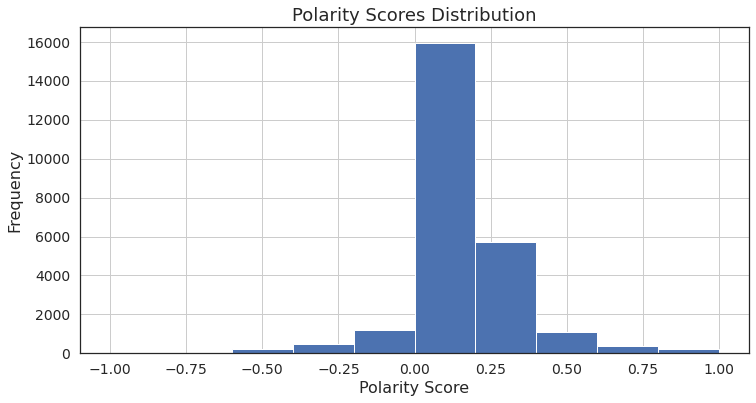

In [35]:
#Plotting the Polarity Scores' distribution

fig = plt.figure(figsize=(12, 6))
data_df['TBScore'].hist()
plt.title('Polarity Scores Distribution', fontsize=18)
plt.xlabel('Polarity Score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [36]:
# Counts and percentages of sentiments
def get_value_counts(col_name):
    count = pd.DataFrame(data_df[col_name].value_counts())
    percentage = pd.DataFrame(data_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,1688,6.66
1,Neutral,9508,37.49
2,Positive,14167,55.86


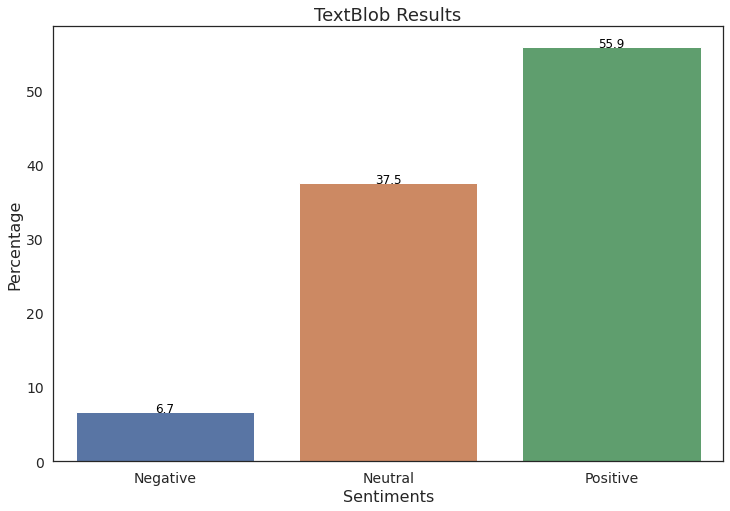

In [37]:
# Barplot showing composition of different sentimets 
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
plt.title('TextBlob Results', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sentiments', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

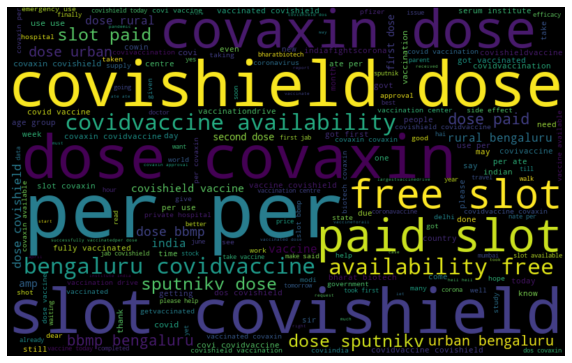

In [38]:
# create text from all tweets
all_words = ' '.join([text for text in data_df['CleanTweet']])
tokens = all_words.strip().split()
clean_tokens = [t for t in tokens if t.isalpha()]
all_words = ' '.join(clean_tokens)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

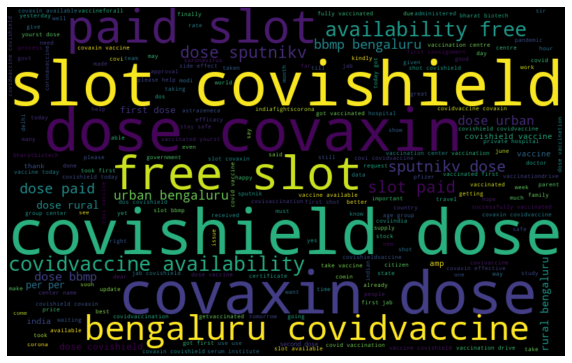

In [39]:
# create text from just positive tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Positive']])
tokens = normal_words.strip().split()
clean_tokens = [t for t in tokens if t.isalpha()]
normal_words = ' '.join(clean_tokens)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

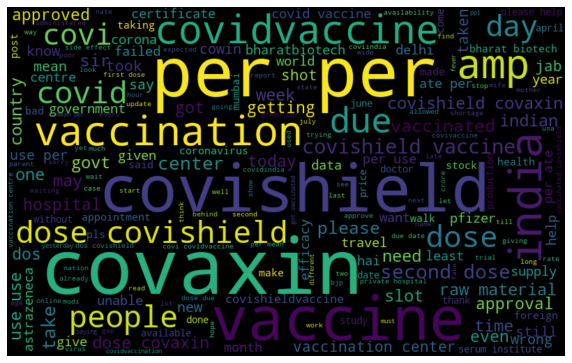

In [40]:
# create text from just negative tweets
normal_words = ' '.join([text for text in data_df['CleanTweet'][data_df['Sentiment'] == 'Negative']])
tokens = normal_words.strip().split()
clean_tokens = [t for t in tokens if t.isalpha()]
normal_words = ' '.join(clean_tokens)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Understanding the impact of Hashtags on tweets sentiment**

In [41]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x.str.lower():
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [42]:
# extracting hashtags from tweets
HT_Positive = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(data_df['OriginalTweet'][data_df['Sentiment'] == 'Negative'])

# unnesting list
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])

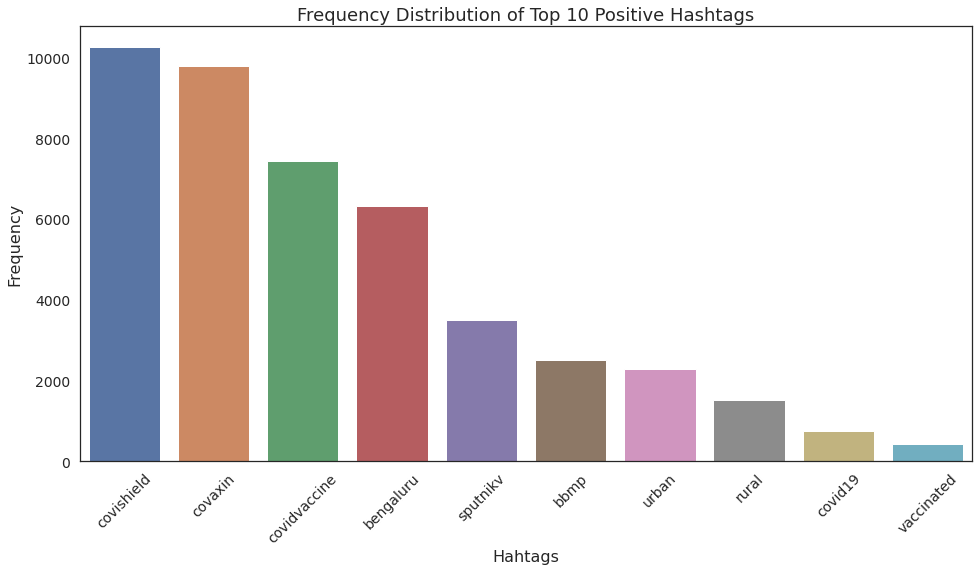

In [46]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count').set_title('Frequency Distribution of Top 10 Positive Hashtags', fontsize=18)
plt.xlabel('Hahtags', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

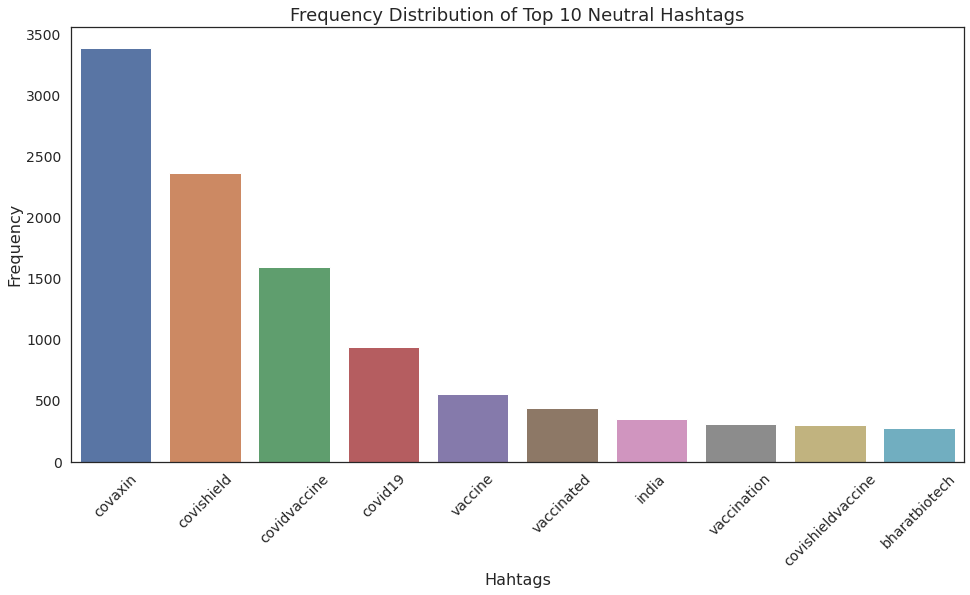

In [47]:
# making frequency distribution top 10 Neutral hashtags
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count').set_title('Frequency Distribution of Top 10 Neutral Hashtags', fontsize=18)
plt.xlabel('Hahtags', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

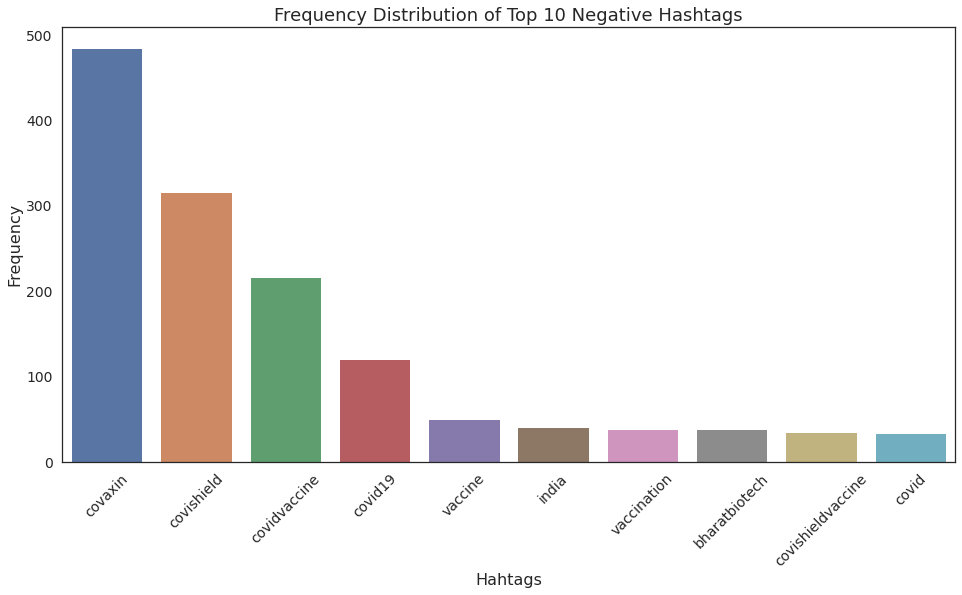

In [48]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,8))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count').set_title('Frequency Distribution of Top 10 Negative Hashtags', fontsize=18)
plt.xlabel('Hahtags', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [49]:
#Checking out the top 10 most Positive tweets (With Polarity of +1)
import pandas as pd
pd.set_option('display.max_colwidth', 160)
data_df.sort_values(by='TBScore', ascending=False)[['CleanTweet', 'TBScore', 'Username']].reset_index(drop=True).head(n=11)

,CleanTweet,TBScore,Username
0,thank hon ble approval covaxin amp covishield emergency use corona vaccination program congratulation best wish scientist bharat biotech serum institute eve...,1.0,pabitrasamantry
1,say modi bungled vaccination one call uddhav best term covaxin unreliable people never change,1.0,SudhirSrinath
2,got myst dose covaxin vaccinated hello everyone taking covi vaccination best step towards fighting pandemic take encourage family friend etc take getvaccina...,1.0,NaN
3,got vaccinated covaxin everything arranged perfectly covaxin vaccinefoplus vaccineforall covidsecondwaveinindia,1.0,DebasisPrahara6
4,awesome one got covaxin covishield,1.0,Biorahul
5,gotst dose covishield mumbai offc awesome setup min thank keeping seafarer priority hoping manning office follow path soon,1.0,Mandar_db
6,today took covishield vaccine district hospital bareilly arrangement praiseworthy behaviour district hospital staff cooperative polite govt excellent job fi...,1.0,OnlyrosesVd
7,wonderful news vaccine covaxin covishield protective variant get vaccinated savul,1.0,PraveenRahi
8,excellent summary covaxin phase trial outcome smkea,1.0,UtpalBorpujari
9,covaxin best vaccine india covid vaccine,1.0,kumar_shrey47


In [50]:
#Checking out the top 10 most Negative tweets (With Polarity of -1)
pd.set_option('display.max_colwidth', 150)
data_df.sort_values(by='TBScore', ascending=True)[['CleanTweet','TBScore','Username']].reset_index(drop=True).head(n=11)

,CleanTweet,TBScore,Username
0,horrible headline given article written pillai covaxin trial gain puvlic attentikn scare monger benefit,-1.0,pgk5192
1,opposition state like kerala punjab chhattisgarh refuse use covaxin even efficacy result insulting india scientist sake politics shame sycs,-1.0,sagrolikarBJP
2,invite covid chc bhagmara pathetic situation covaxin vaccination,-1.0,rajeshvishwa1
3,mumbai airport worst affected covid lost flyer month interval dos covishield extended week covid vaccine virchow biotech make todaypharmanews phar...,-1.0,aiims_pharmacy
4,worst scientist making unscientific noise covaxin,-1.0,neelbs
5,wait till november covaxin approval insane,-1.0,himanshi2311
6,day gap getting dose covaxin bangalore iosing hope availability covaxin would know supply pathetic would gone covishield forst dose covishield sta...,-1.0,C_V_Raghu
7,ful across thr troach anter anthrough aforemention aforement worst worst addition trow ithak uustral covaxin tavel http rave wjqdb,-1.0,vtvgujarati
8,opposition state like kerala punjab an chhattisgarh refuse use covaxin even efficacy result insulting india scientist sake politics shame,-1.0,RealVijayRaina
9,opposition state like kerala punjab an chhattisgarh refuse use covaxin even efficacy result insulting india scientist sake politics shame sipej,-1.0,NaN


Sentiment variation with respect to various months.

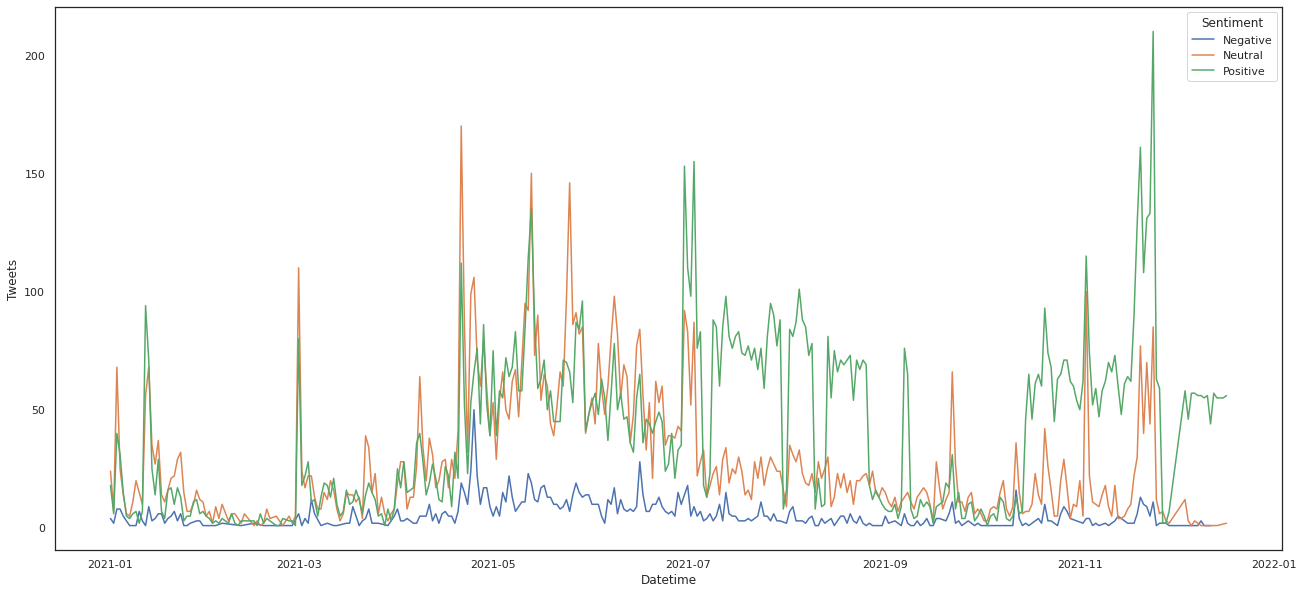

In [51]:
data_df["Datetime"] = data_df['Date']
timeline = data_df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)

#Checking frequency of various tweet words based on their sentiment 

Create a corpus for positive and negative tweets

In [52]:
data_df['TokenizeTweet']=data_df['CleanTweet'].apply(lambda x:word_tokenize(x))

In [53]:
# positive tweets
positive_tweets = data_df[data_df['Sentiment']=='Positive']['TokenizeTweet']
print("Total positive tweets: ", len(positive_tweets))
positive_tweets_words = list(itertools.chain(*positive_tweets))
print("Total words in positive tweets:", len(positive_tweets_words))

# negative tweets
negative_tweets = data_df[data_df['Sentiment']=='Negative']['TokenizeTweet']
print("Total negative tweets: ", len(negative_tweets))
negative_tweets_words = list(itertools.chain(*negative_tweets))
print("Total words in negative tweets:", len(negative_tweets_words))

Total positive tweets:  14167
Total words in positive tweets: 238948
Total negative tweets:  1688
Total words in negative tweets: 29437


Estimate the word frequency in the corpus

In [54]:
positive_words_frequency = collections.Counter(positive_tweets_words)
# top 10 most frequent words in positive reviews
print("Most common positive words:", positive_words_frequency.most_common(10))
negative_words_frequency = collections.Counter(negative_tweets_words)
# top 10 most frequent words in positive reviews
print("Most common negative words:", negative_words_frequency.most_common(10))

Most common positive words: [('dose', 22818), ('do', 19278), ('slot', 13233), ('covishield', 13226), ('covaxin', 11936), ('covidvaccine', 7420), ('free', 6846), ('paid', 6476), ('availability', 6405), ('bengaluru', 6334)]
Most common negative words: [('covaxin', 1043), ('per', 1034), ('covishield', 994), ('vaccine', 701), ('dose', 558), ('vaccination', 294), ('india', 267), ('due', 218), ('covidvaccine', 209), ('amp', 197)]


Visualize the word counts

In [55]:
positive_freq_words_df = pd.DataFrame(positive_words_frequency.most_common(10),
                                     columns=["Word", "Frequency"])
print(positive_freq_words_df)

           Word  Frequency
0          dose      22818
1            do      19278
2          slot      13233
3    covishield      13226
4       covaxin      11936
5  covidvaccine       7420
6          free       6846
7          paid       6476
8  availability       6405
9     bengaluru       6334


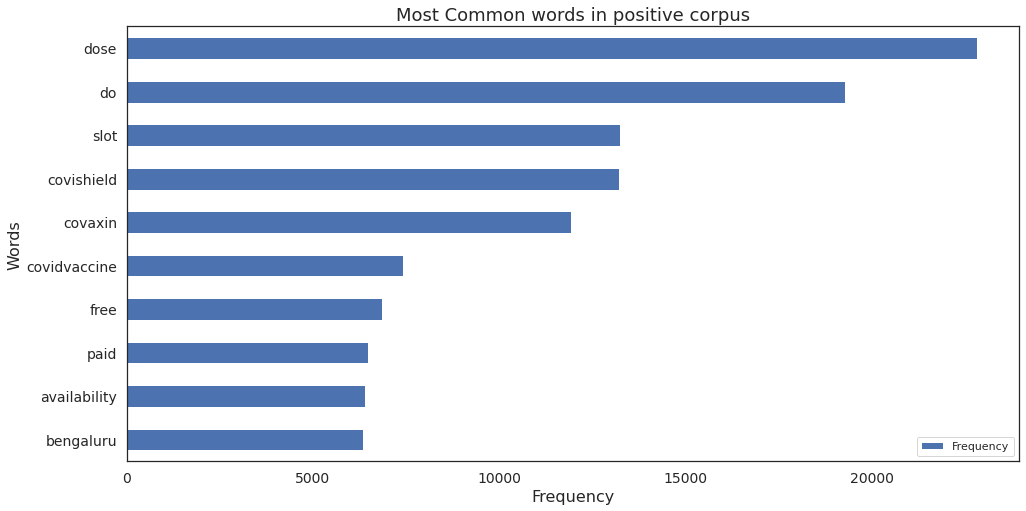

In [56]:
# set figure size
fig, ax = plt.subplots(figsize=(16, 8))
# plot horizontal bar plot
positive_freq_words_df.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
# set the title
plt.title("Most Common words in positive corpus", fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Words', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [57]:
negative_freq_words_df = pd.DataFrame(negative_words_frequency.most_common(10),
                                     columns=["Word", "Frequency"])
print(negative_freq_words_df)

           Word  Frequency
0       covaxin       1043
1           per       1034
2    covishield        994
3       vaccine        701
4          dose        558
5   vaccination        294
6         india        267
7           due        218
8  covidvaccine        209
9           amp        197


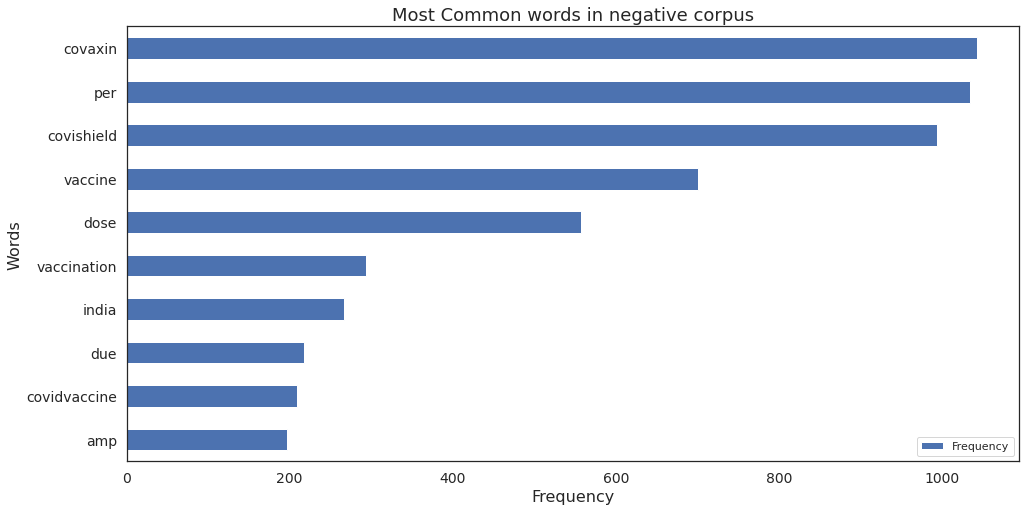

In [58]:
# set figure size
fig, ax = plt.subplots(figsize=(16, 8))
# plot horizontal bar plot
negative_freq_words_df.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
# set the title
plt.title("Most Common words in negative corpus", fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Words', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#Extracting Features from Cleaned Tweets

In [59]:
model_df = data_df[['CleanTweet','Sentiment']]

CONVERTING OUR MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

In [60]:
index_names = model_df[model_df['Sentiment'] == 'Neutral'].index
# drop these row indexes
# from dataFrame
model_df.drop(index_names, inplace = True)

In [61]:
model_df["Sentiment"]= model_df["Sentiment"].replace('Positive',1) 
#model_df["Sentiment"]= model_df["Sentiment"].replace('Neutral',1) 
model_df["Sentiment"]= model_df["Sentiment"].replace('Negative',0) 


In [62]:
model_df.head()

,CleanTweet,Sentiment
3,live covishield get emergency approval india soon coronavirus vaccine reach covishield,1
4,source right historical day india india get vaccine covishield given,1
5,best part covishield vaccine preserved degree standard cold chain,1
7,covidvaccine oxfordastrazenca covishield india best bet aarti subramaniam explains snumsetf,1
12,covishield first vaccine covi available india today approval may take sec,1


In [63]:
model_df['Sentiment'].value_counts()

1    14167
0     1688
Name: Sentiment, dtype: int64

In [64]:
X = model_df.drop('Sentiment', axis=1)
y = model_df.Sentiment

In [65]:
stop = stopwords.words('english')
model_df['CleanTweet'].apply(lambda x: [item for item in x if item not in stop])

3        [l, v, e,  , c, v, h, e, l,  , g, e,  , e, e, r, g, e, n, c,  , p, p, r, v, l,  , n,  , n,  , c, r, n, v, r, u,  , v, c, c, n, e,  , r, e, c, h,  ...
4                                           [u, r, c, e,  , r, g, h,  , h, r, c, l,  ,  , n,  , n,  , g, e,  , v, c, c, n, e,  , c, v, h, e, l,  , g, v, e, n]
5                                  [b, e,  , p, r,  , c, v, h, e, l,  , v, c, c, n, e,  , p, r, e, e, r, v, e,  , e, g, r, e, e,  , n, r,  , c, l,  , c, h, n]
7             [c, v, v, c, c, n, e,  , x, f, r, r, z, e, n, c,  , c, v, h, e, l,  , n,  , b, e,  , b, e,  , r,  , u, b, r, n,  , e, x, p, l, n,  , n, u, e, f]
12                                       [c, v, h, e, l,  , f, r,  , v, c, c, n, e,  , c, v,  , v, l, b, l, e,  , n,  ,  , p, p, r, v, l,  ,  , k, e,  , e, c]
                                                                                 ...                                                                          
39006    [u, r, b, n,  , b, e, n, g, l, u, r, 

In [66]:
model_df.head()

,CleanTweet,Sentiment
3,live covishield get emergency approval india soon coronavirus vaccine reach covishield,1
4,source right historical day india india get vaccine covishield given,1
5,best part covishield vaccine preserved degree standard cold chain,1
7,covidvaccine oxfordastrazenca covishield india best bet aarti subramaniam explains snumsetf,1
12,covishield first vaccine covi available india today approval may take sec,1


In [67]:
#DIVIDING OUR DATASET INTO TRAINING AND TESTING
from sklearn.model_selection import train_test_split

train,valid = train_test_split(model_df,test_size = 0.2,random_state=0,stratify = model_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (12684, 2)
valid shape :  (3171, 2)


In [68]:
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.CleanTweet.values)
X_valid = vectorizer.transform(valid.CleanTweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (12684, 14687)
X_train.shape :  (3171, 14687)
y_train.shape :  (12684,)
y_valid.shape :  (3171,)


In [69]:
#NAIVE BAYES CLASSIFIER FOR BINARY CLASSIFICATION.
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.9191106906338694
Validation accuracy Score :  0.8994008199306213
              precision    recall  f1-score   support

           0       0.72      0.52      0.60       469
           1       0.92      0.97      0.94      2702

    accuracy                           0.90      3171
   macro avg       0.82      0.74      0.77      3171
weighted avg       0.89      0.90      0.89      3171



In [70]:
#RANDOM FOREST CLASSIFIER FOR BINARY CLASSIFICATION
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  1.0
Validation accuracy Score :  0.9426048565121413
              precision    recall  f1-score   support

           0       0.53      0.88      0.66       204
           1       0.99      0.95      0.97      2967

    accuracy                           0.94      3171
   macro avg       0.76      0.91      0.82      3171
weighted avg       0.96      0.94      0.95      3171



In [71]:
#LOGISTIC REGRESSION(BINARY CLASSIFICATION)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9977924944812362
Validation accuracy Score :  0.956480605487228
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       268
           1       0.99      0.96      0.98      2903

    accuracy                           0.96      3171
   macro avg       0.84      0.92      0.87      3171
weighted avg       0.96      0.96      0.96      3171



In [72]:
#XG BOOST( BINARY CLASSIFICATION)
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.9246294544307789
Validation accuracy Score :  0.9205298013245033
              precision    recall  f1-score   support

           0       0.28      0.93      0.42       100
           1       1.00      0.92      0.96      3071

    accuracy                           0.92      3171
   macro avg       0.64      0.93      0.69      3171
weighted avg       0.97      0.92      0.94      3171



In [73]:
#SUPPORT VECTOR MACHINE(BINARY CLASSIFICATION)
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9805266477451908
Validation accuracy Score :  0.9312519709870704
              precision    recall  f1-score   support

           0       0.39      0.92      0.55       142
           1       1.00      0.93      0.96      3029

    accuracy                           0.93      3171
   macro avg       0.69      0.93      0.75      3171
weighted avg       0.97      0.93      0.94      3171



In [74]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.999763481551561
Validation accuracy Score :  0.9599495427309996
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       311
           1       0.98      0.97      0.98      2860

    accuracy                           0.96      3171
   macro avg       0.88      0.91      0.89      3171
weighted avg       0.96      0.96      0.96      3171



In [75]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,Stochastic Gradient Decent,0.959950
1,Logistic Regression,0.956481
2,Random Forest,0.942605
0,Support Vector Machines,0.931252
5,XGBoost,0.920530
3,Naive Bayes,0.899401


#Winner model Logistic Regression	

In [76]:
#LOGISTIC REGRESSION(BINARY CLASSIFICATION)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9977924944812362
Validation accuracy Score :  0.956480605487228
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       268
           1       0.99      0.96      0.98      2903

    accuracy                           0.96      3171
   macro avg       0.84      0.92      0.87      3171
weighted avg       0.96      0.96      0.96      3171



In [77]:
# Get the predicted classes
train_class_preds = logreg.predict(X_train)
test_class_preds = logreg.predict(X_valid)

[[ 1326    24]
 [    4 11330]]


[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

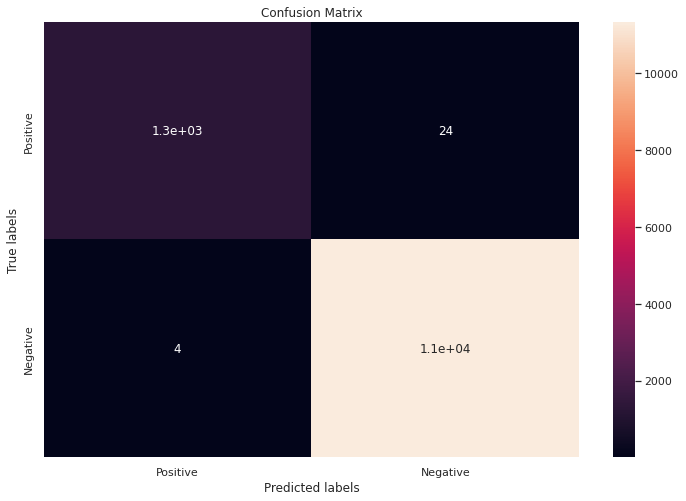

In [78]:
# Get the confusion matrix for both train and test. We are getting very low type and type 2 errors.

labels = ['Positive','Negative']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [79]:
# Let's check the overall accuracy. Overall accuracy is very good.
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

y_pred = logreg.predict(X_valid)
score =accuracy_score(y_valid,y_pred)
print('accuracy is', score)

accuracy is 0.956480605487228


In [80]:
# F1 score for our classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_pred =  logreg.predict(X_valid)
print(f1_score(y_valid,y_pred, average="macro"))

0.8741093251584573


In [81]:
#score is mean accuracy
scikit_score = logreg.score(X_valid,y_valid)
print('scikit score:', scikit_score)

scikit score: 0.956480605487228


In [82]:
# Recall score for our winner model
recall_score(y_valid, y_pred, average='macro')

0.8401531401884385